In [2]:
import torch

def calculate_directions(positions):
    # positions: T x N x 2 的Tensor
    velocities = positions[1:] - positions[:-1]  # 计算速度（位置变化）
    velocities = torch.cat([velocities, velocities[-1].unsqueeze(0)], dim=0)  # 补齐最后一帧
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])  # T x N
    return angles

def filter_neighbors(positions, angles, view_angle=torch.pi/3):
    T, N, _ = positions.shape
    adjacency_matrices = torch.zeros(T, N, N)

    for t in range(T):
        for i in range(N):
            direction_i = angles[t, i]
            positions_relative = positions[t] - positions[t, i]  # 行人i相对于其他所有行人的位置向量
            angles_to_others = torch.atan2(positions_relative[:, 1], positions_relative[:, 0])
            
            # 计算是否在视野内
            lower_bounds = direction_i - view_angle
            upper_bounds = direction_i + view_angle
            
            in_view = (angles_to_others > lower_bounds) & (angles_to_others < upper_bounds)
            in_view[i] = False  # 排除自身
            
            adjacency_matrices[t, i] = in_view.float()  # 更新邻接矩阵

    return adjacency_matrices

# 示例数据
positions = torch.tensor([
    [[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]],
    [[1.0, 0.0], [2.0, 1.0], [3.0, 2.0]],
    [[2.0, 0.0], [3.0, 1.0], [4.0, 2.0]],
    [[3.0, 0.0], [4.0, 1.0], [5.0, 2.0]],
    [[4.0, 0.0], [5.0, 1.0], [6.0, 2.0]]
], dtype=torch.float32)  # T x N x 2

angles = calculate_directions(positions)
adjacency_matrices = filter_neighbors(positions, angles)

print("Adjacency Matrices:\n", adjacency_matrices)

Adjacency Matrices:
 tensor([[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]]])


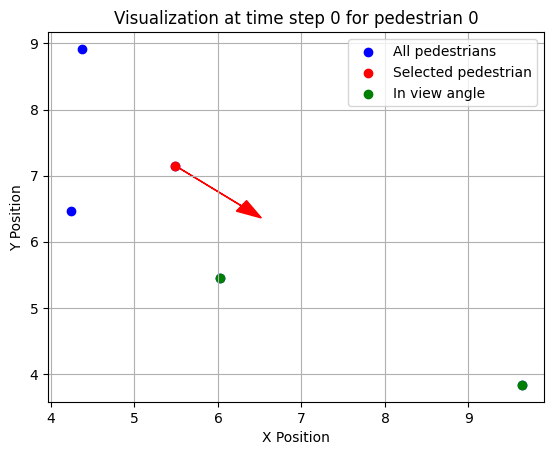

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def calculate_directions(positions):
    # 计算位置变化得到速度向量
    velocities = positions[1:] - positions[:-1]
    velocities = torch.cat([velocities, velocities[-1].unsqueeze(0)], dim=0)
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])  # T x N
    return angles

def filter_neighbors(positions, angles, view_angle=torch.pi):
    T, N, _ = positions.shape
    adjacency_matrices = torch.zeros(T, N, N)

    for t in range(T):
        for i in range(N):
            direction_i = angles[t, i]
            positions_relative = positions[t] - positions[t, i]
            angles_to_others = torch.atan2(positions_relative[:, 1], positions_relative[:, 0])
            
            lower_bounds = direction_i - view_angle
            upper_bounds = direction_i + view_angle
            
            in_view = (angles_to_others > lower_bounds) & (angles_to_others < upper_bounds)
            in_view[i] = False  # 排除自身
            
            adjacency_matrices[t, i] = in_view.float()

    return adjacency_matrices

def visualize_positions(t, i, positions, adjacency_matrix, angles):
    fig, ax = plt.subplots()
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')

    direction = angles[t, i]
    length = 1.0  # 箭头的长度
    ax.arrow(positions[t, i, 0], positions[t, i, 1], 
             length * np.cos(direction), length * np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    # 画出视野内的行人
    for j in range(len(adjacency_matrix[t, i])):
        if adjacency_matrix[t, i, j] == 1:
            ax.scatter(positions[t, j, 0], positions[t, j, 1], color='green', label='In view angle')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.show()

# 示例数据
np.random.seed(0)
positions = torch.tensor(np.random.rand(5, 5, 2) * 10, dtype=torch.float32)  # T x N x 2
angles = calculate_directions(positions)
adjacency_matrices = filter_neighbors(positions, angles, view_angle=torch.pi/2)

# 可视化第3个时间步，第1个行人的视角
visualize_positions(0, 0, positions, adjacency_matrices, angles)


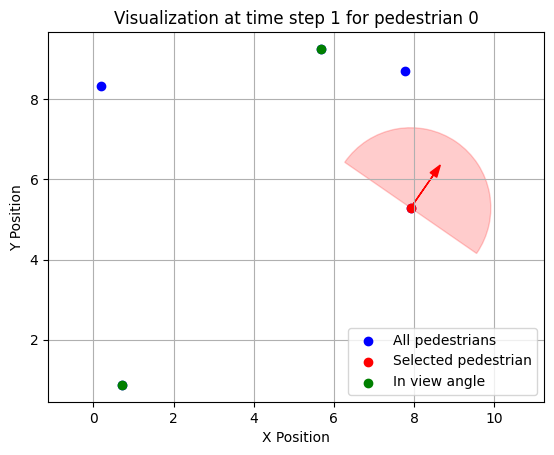

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def calculate_directions(positions):
    velocities = positions[1:] - positions[:-1]
    velocities = torch.cat([velocities, velocities[-1].unsqueeze(0)], dim=0)
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])
    return angles

def visualize_positions_with_view_cone(t, i, positions, adjacency_matrix, angles, view_angle=np.pi/2):
    fig, ax = plt.subplots()
    # 绘制所有行人的位置
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    # 特别标出选择的行人
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')
    
    # 绘制视野扇形
    direction = angles[t, i].item()  # 当前行人的朝向角度
    radius = 2  # 视野半径设定
    wedge = Wedge((positions[t, i, 0], positions[t, i, 1]), radius, 
                  np.degrees(direction - view_angle), np.degrees(direction + view_angle),
                  color='red', alpha=0.2)
    ax.add_patch(wedge)

    # 绘制方向箭头
    ax.arrow(positions[t, i, 0], positions[t, i, 1], 
             np.cos(direction), np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    # 标出视野内的行人
    for j in range(len(adjacency_matrix[t, i])):
        if adjacency_matrix[t, i, j] == 1:
            ax.scatter(positions[t, j, 0], positions[t, j, 1], color='green', label='In view angle')

    # 添加图例和其他细节
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # 去除重复的图例项
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.axis('equal')  # 保证x轴和y轴的刻度一致
    plt.show()

np.random.seed(0)
positions = torch.tensor(np.random.rand(5, 5, 2) * 10, dtype=torch.float32)  # T x N x 2

angles = calculate_directions(positions)
adjacency_matrices = torch.ones(5, 3, 3) - torch.eye(3)  # 假设所有行人均可见（为了演示）

# 可视化第3个时间步的第1个行人的视角
visualize_positions_with_view_cone(1, 0, positions, adjacency_matrices, angles)


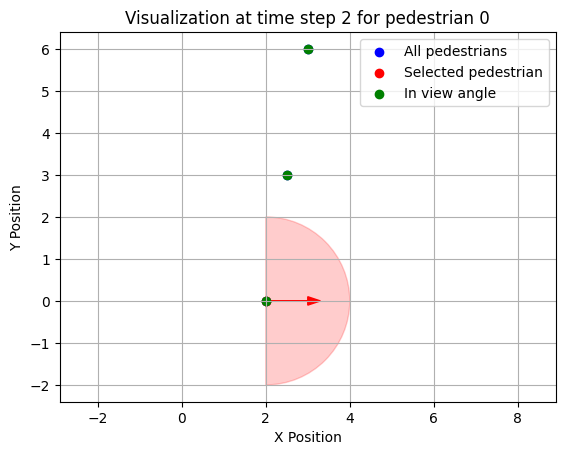

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def calculate_directions(positions):
    velocities = positions[1:] - positions[:-1]
    velocities = torch.cat([velocities, velocities[-1].unsqueeze(0)], dim=0)
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])
    return angles

def visualize_positions_with_view_cone(t, i, positions, adjacency_matrix, angles, view_angle=np.pi/3):
    fig, ax = plt.subplots()
    # 绘制所有行人的位置
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    # 特别标出选择的行人
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')
    
    # 绘制视野扇形
    direction = angles[t, i].item()  # 当前行人的朝向角度
    radius = 2  # 视野半径设定
    wedge = Wedge((positions[t, i, 0], positions[t, i, 1]), radius, 
                  np.degrees(direction - view_angle), np.degrees(direction + view_angle),
                  color='red', alpha=0.2)
    ax.add_patch(wedge)

    # 绘制方向箭头
    ax.arrow(positions[t, i, 0], positions[t, i, 1], 
             np.cos(direction), np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    # 标出视野内的行人
    for j in range(len(adjacency_matrix[t, i])):
        position_j = positions[t, j]
        relative_position = position_j - positions[t, i]
        angle_to_j = torch.atan2(relative_position[1], relative_position[0])
        if angle_to_j < 0:
            angle_to_j += 2 * np.pi  # 规范化为0到2π
        
        angle_low = direction - view_angle
        angle_high = direction + view_angle

        # 角度规范化与比较
        if angle_low < 0:
            angle_low += 2 * np.pi
        if angle_high >= 2 * np.pi:
            angle_high -= 2 * np.pi

        # 检查是否在视野内
        if angle_low < angle_high:
            in_view = angle_low <= angle_to_j <= angle_high
        else:  # 跨越0度线
            in_view = angle_to_j <= angle_high or angle_to_j >= angle_low

        if in_view:
            ax.scatter(position_j[0], position_j[1], color='green', label='In view angle')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # 去除重复的图例项
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 可视化第2个时间步的第1个行人的视角
visualize_positions_with_view_cone(2, 0, positions, adjacency_matrices, angles, view_angle=np.pi/2)


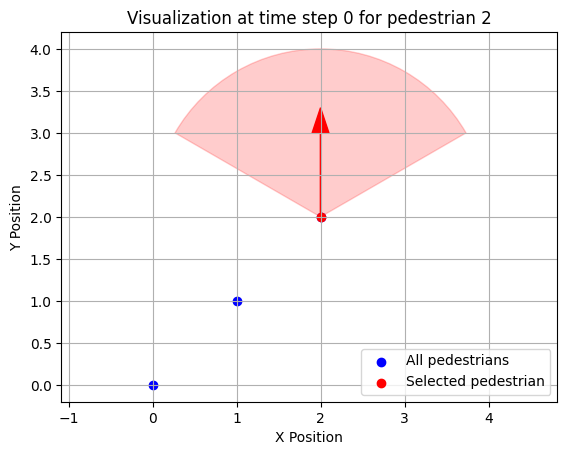

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

def calculate_directions(positions):
    velocities = positions[1:] - positions[:-1]
    if velocities.size(0) < positions.size(0):
        velocities = torch.cat([velocities, velocities[-1:].repeat(1, 1, 1)], dim=0)
    angles = torch.atan2(velocities[:, :, 1], velocities[:, :, 0])
    return angles

def filter_neighbors(positions, angles, view_angle=np.pi/3):
    T, N, _ = positions.shape
    adjacency_matrices = torch.zeros(T, N, N, dtype=torch.float)
    for t in range(T):
        for i in range(N):
            direction_i = angles[t, i]
            for j in range(N):
                if i != j:
                    other_pos = positions[t, j]
                    relative_position = other_pos - positions[t, i]
                    angle_to_other = torch.atan2(relative_position[1], relative_position[0]) - direction_i
                    angle_to_other = (angle_to_other + np.pi) % (2 * np.pi) - np.pi
                    if -view_angle <= angle_to_other <= view_angle:
                        adjacency_matrices[t, i, j] = 1
    return adjacency_matrices

def visualize_positions_with_view_cone(t, i, positions, adjacency_matrix, angles, view_angle=np.pi/3):
    fig, ax = plt.subplots()
    ax.scatter(positions[t, :, 0], positions[t, :, 1], color='blue', label='All pedestrians')
    ax.scatter(positions[t, i, 0], positions[t, i, 1], color='red', label='Selected pedestrian')

    direction = angles[t, i].item()
    radius = 2
    wedge = Wedge((positions[t, i, 0], positions[t, i, 1]), radius, 
                  np.degrees(direction - view_angle), np.degrees(direction + view_angle),
                  color='red', alpha=0.2)
    ax.add_patch(wedge)
    ax.arrow(positions[t, i, 0], positions[t, i, 1], 
             np.cos(direction), np.sin(direction), 
             head_width=0.2, head_length=0.3, fc='red', ec='red')

    for j in range(len(adjacency_matrix[t, i])):
        if adjacency_matrix[t, i, j] == 1:
            ax.scatter(positions[t, j, 0], positions[t, j, 1], color='green', label='In view angle')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Visualization at time step {t} for pedestrian {i}')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 生成数据
# positions = torch.tensor(np.random.rand(5, 5, 2) * 10, dtype=torch.float32)  # T x N x 2

positions = torch.tensor([
    [[0.0, 0.0], [1.0, 1.0], [2.0, 2.0]],
    [[1.0, 0.0], [1.5, 2.0], [2.0, 4.0]],  # 修改行人2的轨迹
    [[2.0, 0.0], [2.5, 3.0], [3.0, 6.0]],  # 修改行人3的轨迹
    [[3.0, 0.0], [3.5, 4.0], [4.0, 8.0]],  # 修改行人3的轨迹
    [[4.0, 0.0], [4.5, 5.0], [5.0, 10.0]]  # 修改行人3的轨迹
], dtype=torch.float32)  # T x N x 2

angles = calculate_directions(positions)
adjacency_matrices = filter_neighbors(positions, angles)

# 可视化第3个时间步的第1个行人的视角
visualize_positions_with_view_cone(0, 2, positions, adjacency_matrices, angles)


In [17]:
adjacency_matrices

tensor([[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.]]])